In [3]:
# Pasting these here for easier access

import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count
import os
import sys
import time
import datetime 
from math import *

# 04/22/2025

# Continuing the examination of the PKPD curves of different weight groups to figure out where the bug is

<br>

---

<br>

# Objective 1: Creating PKPD curves for weight groups > 15, > 25, > 35 and <= 35
<br>

---
    
# Using previously calibrated --pmax_artemether 0.9999994 and --ec50_lum 64 values

--- 

### Function call to examine state values of one weight group

In [123]:
# Function to run a single simulation for a given weight value

def run_single_weight_simulation(weight):
    start_time = time.monotonic()
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "500",
        "--pmax_artemether", "0.9999994",
        "--ec50_lum", "64",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split() for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        
        end_time = time.monotonic()
        today = datetime.date.today()
        print("\nToday's date: ", today, "\n")
        print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

        return efficacy, df_weight, failed_treatment_count
        
    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

### Weight: 10 Kg

In [124]:
# Define the weight values to use
#weight_values = [10, 15, 20, 30, 40]

weight_values = [10]

for weight in weight_values:

        params_file_artemether = f"PK_parameters_{weight}kg_artemether.txt"
        if os.path.isfile(params_file_artemether):
                os.remove(params_file_artemether)

        params_file_lumefantrine = f"PK_parameters_{weight}kg_lumefantrine.txt"
        if os.path.isfile(params_file_lumefantrine):
                os.remove(params_file_lumefantrine)
        
        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg.csv", index=False)
        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")



Today's date:  2025-04-23 

Length of simulation:  0:00:12.527131 


The failed treatment count for weight 10kg is: 401

The percentage efficacy for weight 10kg is: 19.799999999999997 



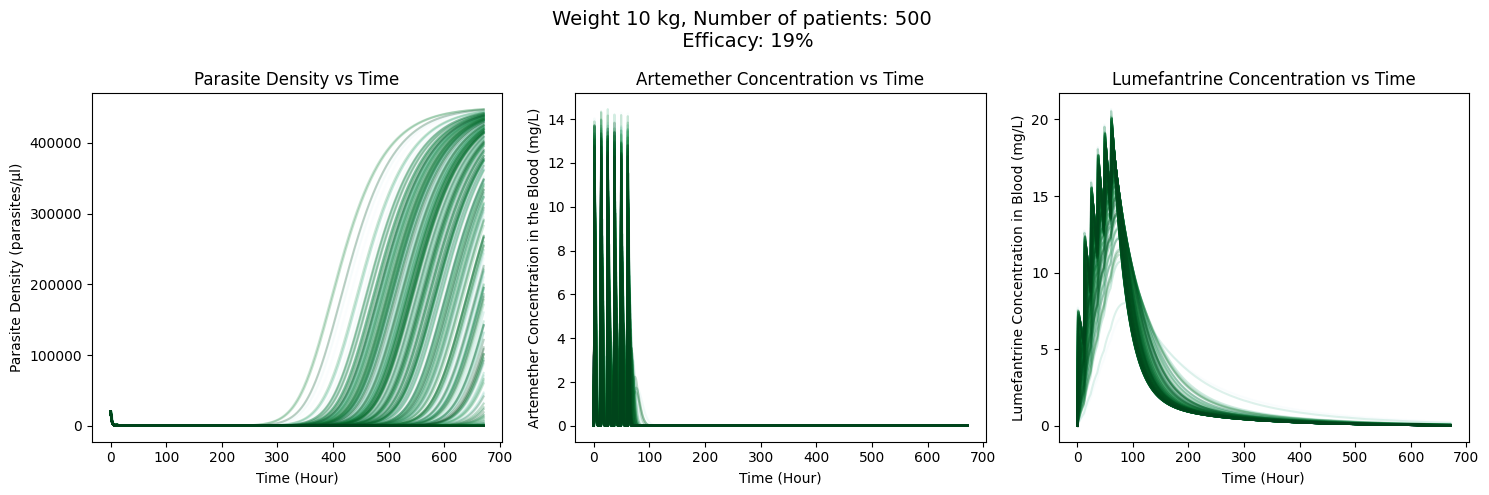

In [125]:
#Plot parasite density, artemisinin and lumefantrine concentration for weight group 2, run 2, patient weight = 8kg

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())

# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

plt.subplot(1, 3, 1)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['PARASITEDENSITY'], color='blue')
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasites/μl)')
plt.title('Parasite Density vs Time')

plt.subplot(1, 3, 2)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_ART'], color='red')
plt.xlabel('Time (Hour)')
plt.ylabel('Artemether Concentration in the Blood (mg/L)')
plt.title('Artemether Concentration vs Time')

plt.subplot(1, 3, 3)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_LUM'], color='green')
plt.xlabel('Time (Hour)')
plt.ylabel('Lumefantrine Concentration in Blood (mg/L)')
plt.title('Lumefantrine Concentration vs Time')

# Add title for the entire figure
plt.suptitle(f"Weight {weight} kg, Number of patients: {num_pids} \n Efficacy: {floor(efficacy)}%", fontsize=14)
plt.tight_layout()
plt.savefig(f"df_weight_{weight}kg.png")
plt.show()


<br>

### Weight: 20 Kg

In [126]:
weight_values = [20]

for weight in weight_values:

        params_file_artemether = f"PK_parameters_{weight}kg_artemether.txt"
        if os.path.isfile(params_file_artemether):
                os.remove(params_file_artemether)

        params_file_lumefantrine = f"PK_parameters_{weight}kg_lumefantrine.txt"
        if os.path.isfile(params_file_lumefantrine):
                os.remove(params_file_lumefantrine)
        
        
        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg.csv", index=False)
        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")


Today's date:  2025-04-23 

Length of simulation:  0:00:12.041661 


The failed treatment count for weight 20kg is: 187

The percentage efficacy for weight 20kg is: 62.6 



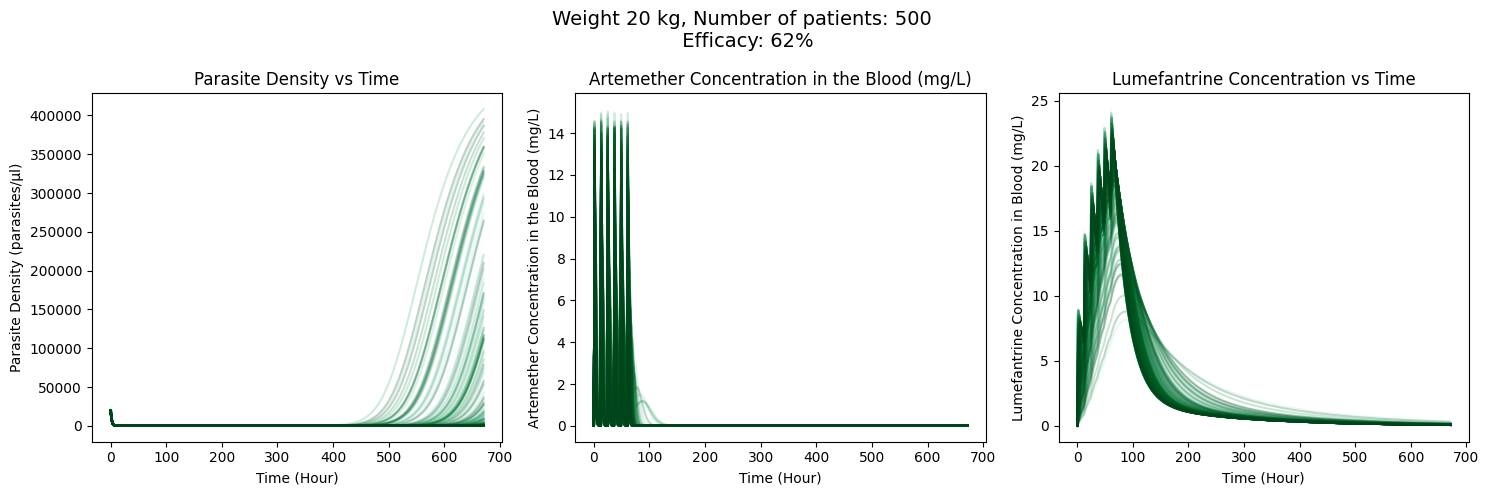

In [127]:
#Plot parasite density, artemisinin and lumefantrine concentration for weight group 2, run 2, patient weight = 8kg

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())

# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

plt.subplot(1, 3, 1)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['PARASITEDENSITY'], color='blue')
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasites/μl)')
plt.title('Parasite Density vs Time')

plt.subplot(1, 3, 2)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_ART'], color='red')
plt.xlabel('Time (Hour)')
plt.ylabel('Artemether Concentration in the Blood (mg/L)')
plt.title('Artemether Concentration in the Blood (mg/L)')

plt.subplot(1, 3, 3)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_LUM'], color='green')
plt.xlabel('Time (Hour)')
plt.ylabel('Lumefantrine Concentration in Blood (mg/L)')
plt.title('Lumefantrine Concentration vs Time')

# Add title for the entire figure
plt.suptitle(f"Weight {weight} kg, Number of patients: {num_pids} \n Efficacy: {floor(efficacy)}%", fontsize=14)
plt.tight_layout()
plt.savefig(f"df_weight_{weight}kg.png")
plt.show()


<br>

### Weight: 30 Kg

In [128]:
weight_values = [30]

for weight in weight_values:

        params_file_artemether = f"PK_parameters_{weight}kg_artemether.txt"
        if os.path.isfile(params_file_artemether):
                os.remove(params_file_artemether)

        params_file_lumefantrine = f"PK_parameters_{weight}kg_lumefantrine.txt"
        if os.path.isfile(params_file_lumefantrine):
                os.remove(params_file_lumefantrine)
        
        
        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg.csv", index=False)
        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")


Today's date:  2025-04-23 

Length of simulation:  0:00:12.867691 


The failed treatment count for weight 30kg is: 88

The percentage efficacy for weight 30kg is: 82.4 



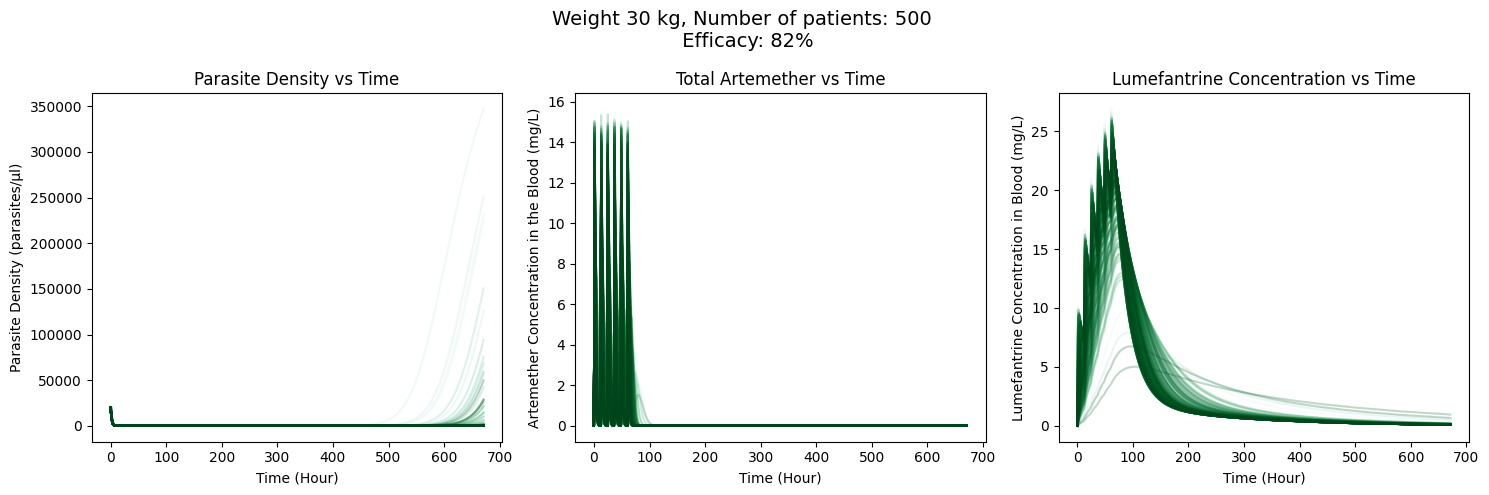

In [129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())

# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

plt.subplot(1, 3, 1)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['PARASITEDENSITY'], color='blue')
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasites/μl)')
plt.title('Parasite Density vs Time')

plt.subplot(1, 3, 2)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_ART'], color='red')
plt.xlabel('Time (Hour)')
plt.ylabel('Artemether Concentration in the Blood (mg/L)')
plt.title('Total Artemether vs Time')

plt.subplot(1, 3, 3)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_LUM'], color='green')
plt.xlabel('Time (Hour)')
plt.ylabel('Lumefantrine Concentration in Blood (mg/L)')
plt.title('Lumefantrine Concentration vs Time')

# Add title for the entire figure
plt.suptitle(f"Weight {weight} kg, Number of patients: {num_pids} \n Efficacy: {floor(efficacy)}%", fontsize=14)
plt.tight_layout()
plt.savefig(f"df_weight_{weight}kg.png")
plt.show()


<br>

### Weight: 40 Kg

In [130]:
weight_values = [40]

for weight in weight_values:

        params_file_artemether = f"PK_parameters_{weight}kg_artemether.txt"
        if os.path.isfile(params_file_artemether):
                os.remove(params_file_artemether)

        params_file_lumefantrine = f"PK_parameters_{weight}kg_lumefantrine.txt"
        if os.path.isfile(params_file_lumefantrine):
                os.remove(params_file_lumefantrine)
        
        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg.csv", index=False)
        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")


Today's date:  2025-04-23 

Length of simulation:  0:00:14.185032 


The failed treatment count for weight 40kg is: 34

The percentage efficacy for weight 40kg is: 93.2 



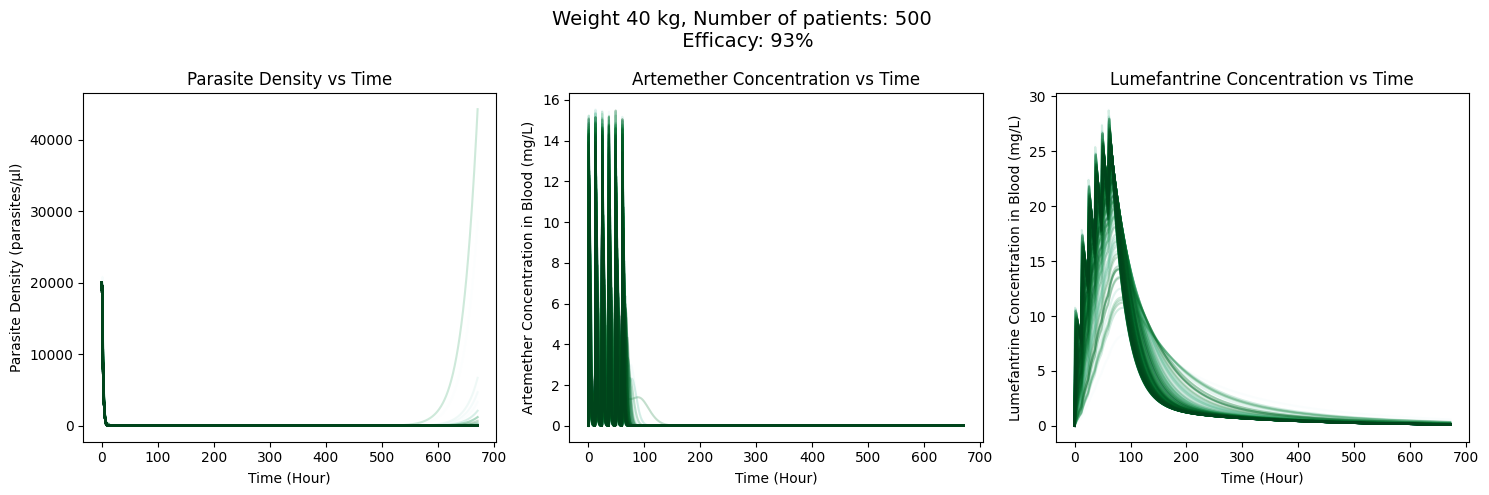

In [131]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())

# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

plt.subplot(1, 3, 1)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['PARASITEDENSITY'], color='blue')
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasites/μl)')
plt.title('Parasite Density vs Time')

plt.subplot(1, 3, 2)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_ART'], color='red')
plt.xlabel('Time (Hour)')
plt.ylabel('Artemether Concentration in Blood (mg/L)')
plt.title('Artemether Concentration vs Time')

plt.subplot(1, 3, 3)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_LUM'], color='green')
plt.xlabel('Time (Hour)')
plt.ylabel('Lumefantrine Concentration in Blood (mg/L)')
plt.title('Lumefantrine Concentration vs Time')

# Add title for the entire figure
plt.suptitle(f"Weight {weight} kg, Number of patients: {num_pids} \n Efficacy: {floor(efficacy)}%", fontsize=14)
plt.tight_layout()
plt.savefig(f"df_weight_{weight}kg.png")
plt.show()

In [14]:
# Load the dataframes
# Calculate the efficacy for each weight group

failed_treatment_count = []
efficacy = []
df_weight_compiled = []

for weight in [10, 20, 30, 40]:
    # Load the dataframe
    df_weight = pd.read_pickle(f"df_weight_{weight}kg.pyobj")
    # Calculate the efficacy
    failed_treatment_count.append(df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0])
    total_patients = df_weight['PID'].nunique()
    efficacy.append((1 - (failed_treatment_count[-1] / total_patients)) * 100 if total_patients > 0 else np.nan)
    # Append the dataframe to the list
    df_weight_compiled.append(df_weight)
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Weight': [10, 20, 30, 40],
    'Failed Treatment Count': failed_treatment_count,
    'Efficacy': efficacy
})

# Save the results to a CSV file
results_df.to_csv("efficacy_results_compiled.csv", index=False)
# Save the results to a pickle file
results_df.to_pickle("efficacy_results_compiled.pyobj")
# Print the results
print("\nEfficacy Results:")
print(results_df)
 


Efficacy Results:
   Weight  Failed Treatment Count  Efficacy
0      10                     401      19.8
1      20                     187      62.6
2      30                      88      82.4
3      40                      34      93.2


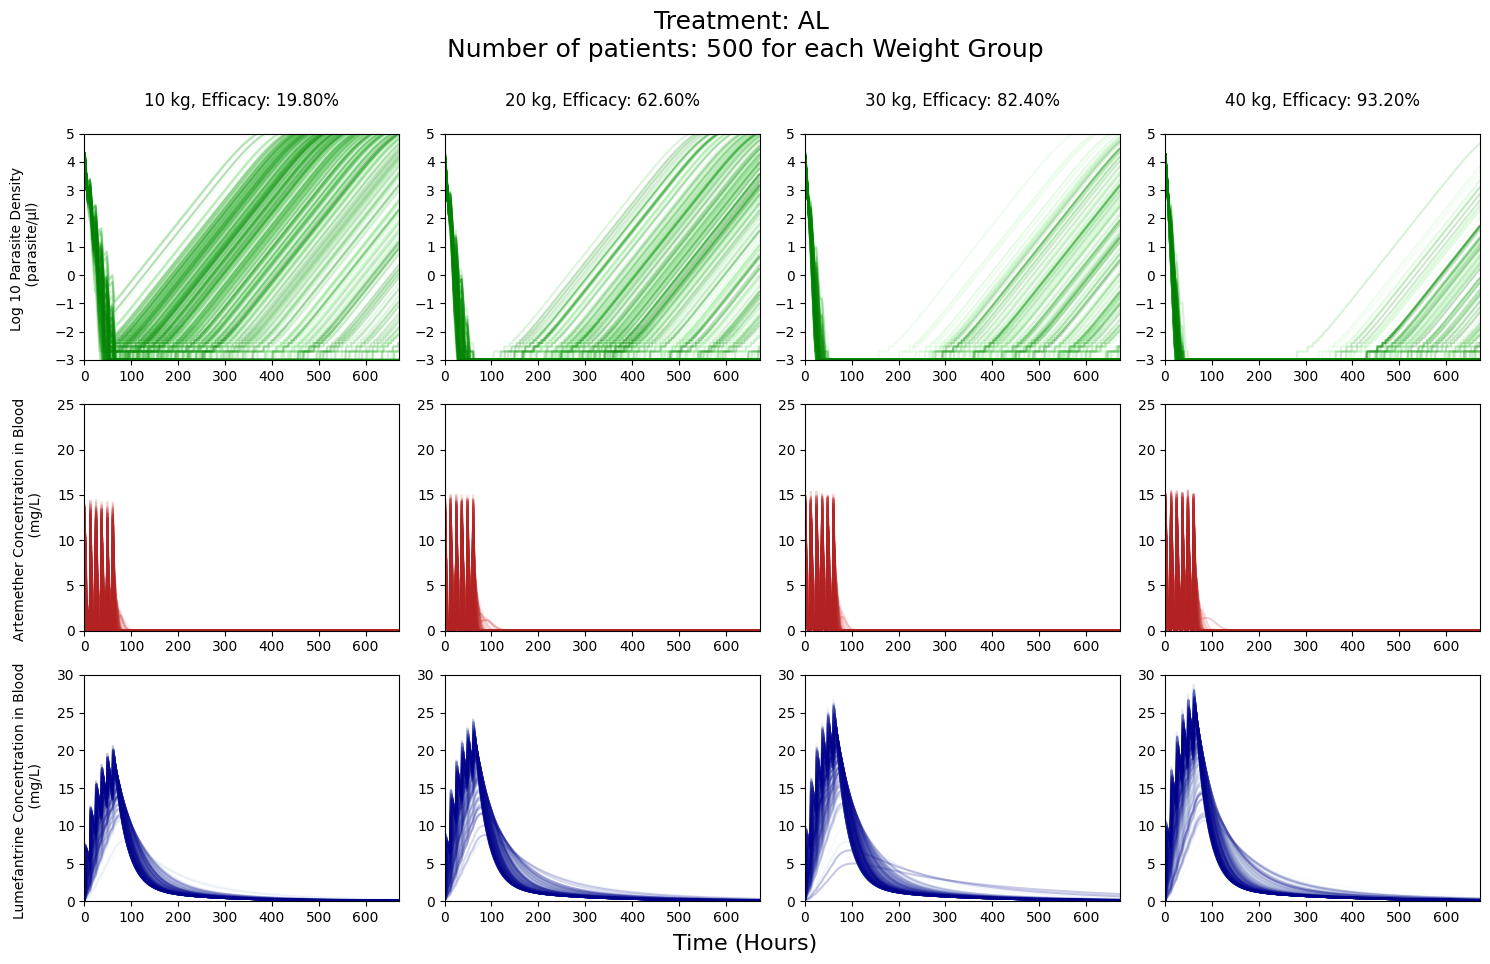

In [ ]:
import math
from matplotlib.colors import LinearSegmentedColormap

if len(df_weight_compiled) >= 4:
    df_dict = {10: df_weight_compiled[0], 20: df_weight_compiled[1], 30: df_weight_compiled[2], 40: df_weight_compiled[3]}
else:
    print("Error: df_weight_compiled does not have enough elements.")

# Create a 4x3 subplot (3 variables, 4 weightgroups)
fig, ax = plt.subplots(3, 4, figsize=(15, 10), sharex=True, sharey=False)

# Define colormaps for each plot
green_cmap = LinearSegmentedColormap.from_list("green_cmap", ["white", "lightgreen", "green"])  # Softer green for Parasite Density
red_cmap = LinearSegmentedColormap.from_list("red_cmap", ["white", "lightcoral", "firebrick"])  # Softer red for Artemether
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["white", "lightsteelblue", "darkblue"])  # Softer blue for Lumefantrine

# Iterate over weight groups
for i, weight in enumerate([10, 20, 30, 40]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid].copy()
        df_pid['LOG10_PARASITEDENSITY'] = np.log10(df_pid['PARASITEDENSITY'] + 0.001)
        color = green_cmap(norm(j))
        ax[0, i].plot(df_pid['HOUR'], df_pid['LOG10_PARASITEDENSITY'], color=color, alpha=0.25)
        ax[0, i].set_ylim(-3, 5)  # Set y-axis limits for Parasite Density

  
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = red_cmap(norm(j))
        ax[1, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
        ax[1, i].set_ylim(0, 25)
        ax[2, i].set_yticks(range(0, 30, 5)) 

    # Plot Lumefantrine Concentration (Row 3) with blue colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = blue_cmap(norm(j))
        ax[2, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
        ax[2, i].set_ylim(0, 30)
        ax[2, i].set_yticks(range(0, 35, 5))  
    

    # Set x-axis limits
    for j in range(3):  # Iterate over rows (0, 1, 2)
        ax[j, i].set_xlim(0, 672)

    # Set row labels on the top row
    ax[0, i].set_title(f'{weight} kg, Efficacy: {results_df[results_df["Weight"] == weight]["Efficacy"].values[0]:.2f}% \n ', fontsize=12, pad=20)

# Set **row titles** (only for the leftmost column)
row_titles = ["Log 10 Parasite Density \n (parasite/μl)", "Artemether Concentration in Blood \n (mg/L)", "Lumefantrine Concentration in Blood \n (mg/L)"]
for j in range(3):
    ax[j, 0].set_ylabel(row_titles[j], fontsize=10, rotation=90, labelpad=10)

# Set x-ticks for all subplots
for i in range(3):  
    for j in range(4):
        ax[i, j].tick_params(labelbottom=True)

fig.text(0.5, 0.04, 'Time (Hours)', ha='center', fontsize=16)

fig.suptitle(f"Treatment: AL \nNumber of patients: {num_pids} for each Weight Group", fontsize=18)

plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust layout to fit common x-label
plt.savefig("df_weight_all_params_all_weights_log10_multicolour_02.png")
plt.show()


In [4]:
pk_params_dfs_artemether = []

for i in range(1, 5):
    pk_params = pd.read_csv(f"PK_parameters_{i}0kg_artemether.txt", sep=",", header=0)
    pk_params_dfs_artemether.append(pk_params)

In [5]:
pk_params_dfs_lumefantrine = []

for i in range(1, 5):
    pk_params = pd.read_csv(f"PK_parameters_{i}0kg_lumefantrine.txt", sep=",", header=0)
    pk_params_dfs_lumefantrine.append(pk_params)

In [6]:
for i in range(0, 4):
    pk_params_dfs_artemether[i].columns = pk_params_dfs_artemether[i].columns.str.replace(' ', '')
    pk_params_dfs_artemether[i].columns = pk_params_dfs_artemether[i].columns.str.replace('/', '_')

    pk_params_dfs_lumefantrine[i].columns = pk_params_dfs_lumefantrine[i].columns.str.replace(' ', '')
    pk_params_dfs_lumefantrine[i].columns = pk_params_dfs_lumefantrine[i].columns.str.replace('/', '_')

In [7]:
pk_params_dfs_lumefantrine[0].columns

Index(['PID', 'i_lum_F1_indiv', 'i_lum_k12(KA)', 'i_lum_k23(Q_V)',
       'i_lum_k32(Q_VP)', 'i_lum_k20(CL_V)', 'total_mg_dose_per_occassion',
       'DS', 'Q', 'V', 'CL', 'VP'],
      dtype='object')

In [8]:
pk_params_dfs_artemether[0].columns

Index(['PID', 'i_artemether_F1_indiv', 'i_artemether_KTR',
       'total_mg_dose_per_occassion', 'TVCL', 'CL', 'TVV2', 'V2',
       'i_artemether_k20(CL_V2)'],
      dtype='object')

In [9]:
artemether_v2_mean = []
artemether_v2_min = []
artemether_v2_max = []

for i in range(4):
    artemether_v2_mean.append(pk_params_dfs_artemether[i]['V2'].mean())
    artemether_v2_min.append(pk_params_dfs_artemether[i]['V2'].min())
    artemether_v2_max.append(pk_params_dfs_artemether[i]['V2'].max())

print("Artemether V2 Mean: ", artemether_v2_mean)
print("Artemether V2 Min: ", artemether_v2_min)
print("Artemether V2 Max: ", artemether_v2_max)

Artemether V2 Mean:  [np.float64(26.760658199999998), np.float64(54.330059), np.float64(80.7957594), np.float64(107.52768619999999)]
Artemether V2 Min:  [np.float64(18.4622), np.float64(33.9019), np.float64(50.7953), np.float64(67.7312)]
Artemether V2 Max:  [np.float64(42.1673), np.float64(78.6197), np.float64(120.404), np.float64(143.944)]


In [315]:
artemether_k20_mean = []
lumefantrine_k23_mean = []
lumefantrine_k20_mean = []
for i in range(4):
    artemether_k20_mean.append(pk_params_dfs_artemether[i]["i_artemether_k20(CL_V2)"].mean())
    lumefantrine_k23_mean.append(pk_params_dfs_lumefantrine[i]["i_lum_k23(Q_V)"].mean())
    lumefantrine_k20_mean.append(pk_params_dfs_lumefantrine[i]["i_lum_k20(CL_V)"].mean())

artemether_k20_min = []
lumefantrine_k23_min = []
lumefantrine_k20_min = []
for i in range(4):
    artemether_k20_min.append(pk_params_dfs_artemether[i]["i_artemether_k20(CL_V2)"].min())
    lumefantrine_k23_min.append(pk_params_dfs_lumefantrine[i]["i_lum_k23(Q_V)"].min())
    lumefantrine_k20_min.append(pk_params_dfs_lumefantrine[i]["i_lum_k20(CL_V)"].min())

artemether_k20_max = []
lumefantrine_k23_max = []
lumefantrine_k20_max = []
for i in range(4):
    artemether_k20_max.append(pk_params_dfs_artemether[i]["i_artemether_k20(CL_V2)"].max())
    lumefantrine_k23_max.append(pk_params_dfs_lumefantrine[i]["i_lum_k23(Q_V)"].max())
    lumefantrine_k20_max.append(pk_params_dfs_lumefantrine[i]["i_lum_k20(CL_V)"].max())



In [325]:
lumefantrine_k32_mean = []
lumefantrine_k32_min = []
lumefantrine_k32_max = []

for i in range(0, 4):
    lumefantrine_k32_mean.append(pk_params_dfs_lumefantrine[i]["i_lum_k32(Q_VP)"].mean())
    lumefantrine_k32_min.append(pk_params_dfs_lumefantrine[i]["i_lum_k32(Q_VP)"].min())
    lumefantrine_k32_max.append(pk_params_dfs_lumefantrine[i]["i_lum_k32(Q_VP)"].max())

print("Lumefantrine k32 mean values: ", lumefantrine_k32_mean)
print("Lumefantrine k32 min values: ", lumefantrine_k32_min)
print("Lumefantrine k32 max values: ", lumefantrine_k32_max)

Lumefantrine k32 mean values:  [np.float64(0.00834678), np.float64(0.007018769999999998), np.float64(0.006342180000000002), np.float64(0.00590206)]
Lumefantrine k32 min values:  [np.float64(0.00834678), np.float64(0.00701877), np.float64(0.00634218), np.float64(0.00590206)]
Lumefantrine k32 max values:  [np.float64(0.00834678), np.float64(0.00701877), np.float64(0.00634218), np.float64(0.00590206)]


In [322]:
for i in range(0, 4):
    print(f"\n\n\n\nArtemether k20 mean for weight {i+1}0kg: {artemether_k20_mean[i]}")
    print(f"Artemether k20 min for weight {i+1}0kg: {artemether_k20_min[i]}")
    print(f"Artemether k20 max for weight {i+1}0kg: {artemether_k20_max[i]}\n")


    print(f"\nLumefantrine k23 mean for weight {i+1}0kg: {lumefantrine_k23_mean[i]}")
    print(f"Lumefantrine k23 min for weight {i+1}0kg: {lumefantrine_k23_min[i]}")
    print(f"Lumefantrine k23 max for weight {i+1}0kg: {lumefantrine_k23_max[i]}\n")


    print(f"\nLumefantrine k20 mean for weight {i+1}0kg: {lumefantrine_k20_mean[i]}")
    print(f"Lumefantrine k20 min for weight {i+1}0kg: {lumefantrine_k20_min[i]}")
    print(f"Lumefantrine k20 max for weight {i+1}0kg: {lumefantrine_k20_max[i]}")





Artemether k20 mean for weight 10kg: 0.906910238
Artemether k20 min for weight 10kg: 0.565995
Artemether k20 max for weight 10kg: 1.29272


Lumefantrine k23 mean for weight 10kg: 0.07708040088
Lumefantrine k23 min for weight 10kg: 0.00198081
Lumefantrine k23 max for weight 10kg: 0.972458


Lumefantrine k20 mean for weight 10kg: 0.30249575914000004
Lumefantrine k20 min for weight 10kg: 0.00777351
Lumefantrine k20 max for weight 10kg: 3.81633




Artemether k20 mean for weight 20kg: 0.752718888
Artemether k20 min for weight 20kg: 0.510539
Artemether k20 max for weight 20kg: 1.18396


Lumefantrine k23 mean for weight 20kg: 0.0588199138
Lumefantrine k23 min for weight 20kg: 0.00184667
Lumefantrine k23 max for weight 20kg: 0.834526


Lumefantrine k20 mean for weight 20kg: 0.2308339432
Lumefantrine k20 min for weight 20kg: 0.00724711
Lumefantrine k20 max for weight 20kg: 3.27503




Artemether k20 mean for weight 30kg: 0.6844771579999999
Artemether k20 min for weight 30kg: 0.451844
Artem

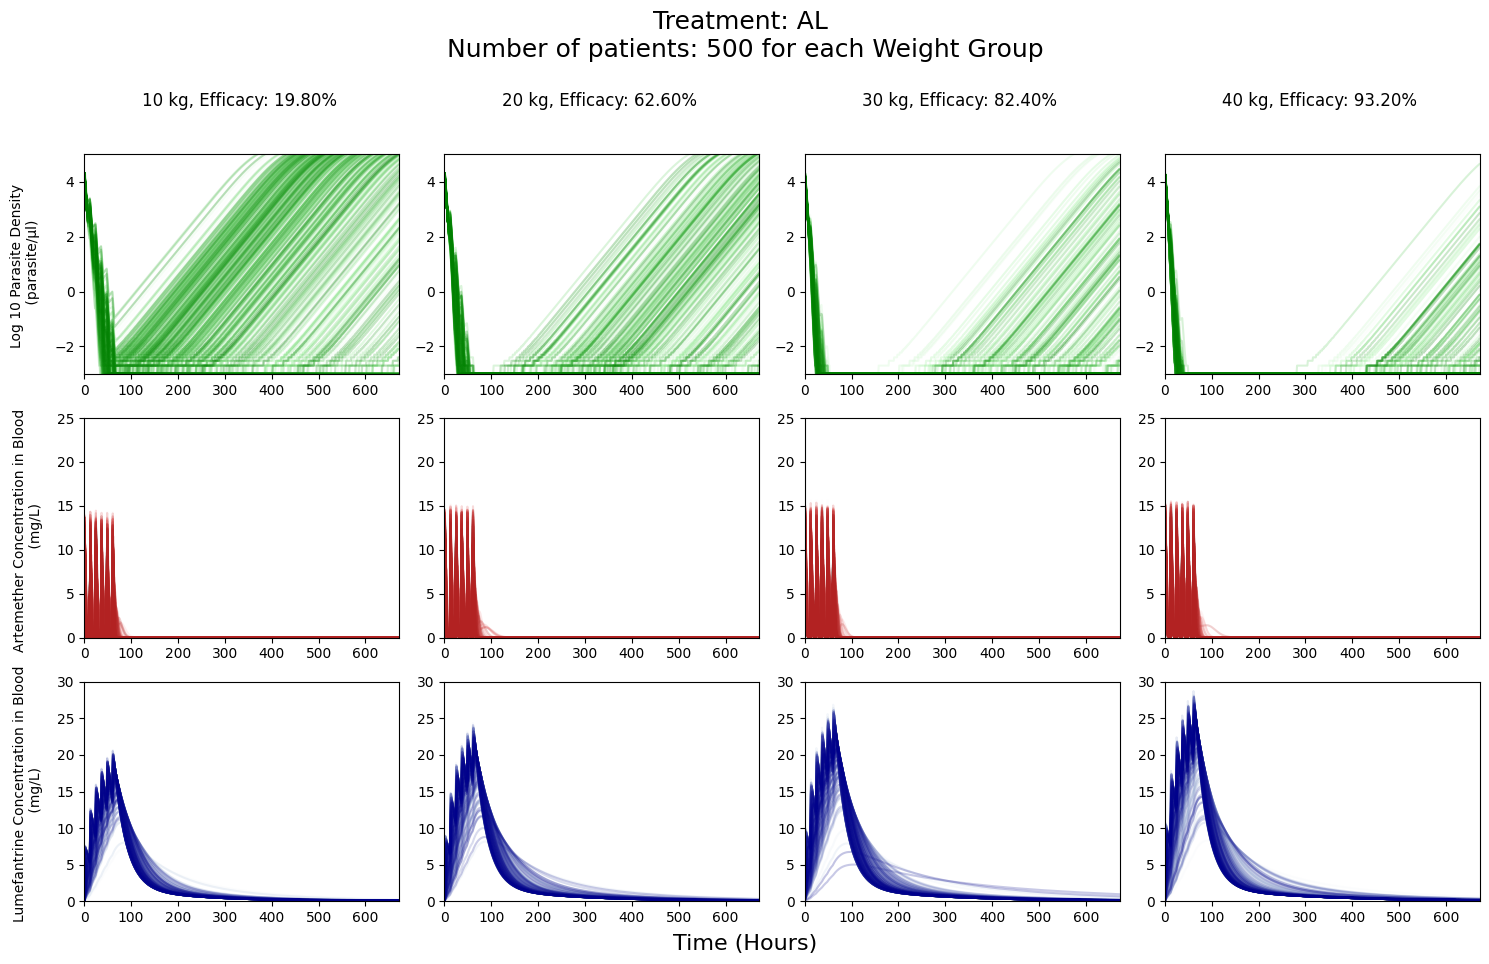

In [312]:

from matplotlib.colors import LinearSegmentedColormap

if len(df_weight_compiled) >= 4:
    df_dict = {10: df_weight_compiled[0], 20: df_weight_compiled[1], 30: df_weight_compiled[2], 40: df_weight_compiled[3]}
else:
    print("Error: df_weight_compiled does not have enough elements.")

# Create a 4x3 subplot (3 variables, 4 weightgroups)
fig, ax = plt.subplots(3, 4, figsize=(15, 10), sharex=True, sharey=False)

# Define colormaps for each plot
green_cmap = LinearSegmentedColormap.from_list("green_cmap", ["white", "lightgreen", "green"])  # Softer green for Parasite Density
red_cmap = LinearSegmentedColormap.from_list("red_cmap", ["white", "lightcoral", "firebrick"])  # Softer red for Artemether
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["white", "lightsteelblue", "darkblue"])  # Softer blue for Lumefantrine

# Iterate over weight groups
for i, weight in enumerate([10, 20, 30, 40]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid].copy()
        df_pid['LOG10_PARASITEDENSITY'] = np.log10(df_pid['PARASITEDENSITY'] + 0.001)
        color = green_cmap(norm(j))
        ax[0, i].plot(df_pid['HOUR'], df_pid['LOG10_PARASITEDENSITY'], color=color, alpha=0.25)
        ax[0, i].set_ylim(-3, 5)  # Set y-axis limits for Parasite Density

  
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = red_cmap(norm(j))
        ax[1, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
        ax[1, i].set_ylim(0, 25)
        ax[2, i].set_yticks(range(0, 30, 5)) 

    # Plot Lumefantrine Concentration (Row 3) with blue colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = blue_cmap(norm(j))
        ax[2, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
        ax[2, i].set_ylim(0, 30)
        ax[2, i].set_yticks(range(0, 35, 5))  
    

    # Set x-axis limits
    for j in range(3):  # Iterate over rows (0, 1, 2)
        ax[j, i].set_xlim(0, 672)

    # Set row labels on the top row
    ax[0, i].set_title(f'{weight} kg, Efficacy: {results_df[results_df["Weight"] == weight]["Efficacy"].values[0]:.2f}% \n ', fontsize=12, pad=20)

# Set **row titles** (only for the leftmost column)
row_titles = ["Log 10 Parasite Density \n (parasite/μl)", "Artemether Concentration in Blood \n (mg/L)", "Lumefantrine Concentration in Blood \n (mg/L)"]
for j in range(3):
    ax[j, 0].set_ylabel(row_titles[j], fontsize=10, rotation=90, labelpad=10)

# Set x-ticks for all subplots
for i in range(3):  
    for j in range(4):
        ax[i, j].tick_params(labelbottom=True)

fig.text(0.5, 0.04, 'Time (Hours)', ha='center', fontsize=16)

fig.suptitle(f"Treatment: AL \nNumber of patients: {num_pids} for each Weight Group", fontsize=18)

plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust layout to fit common x-label
plt.savefig("df_weight_all_params_all_weights_log10_multicolour_02.png")
plt.show()


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_pk_params(df_weight_compiled, weight_labels):
    """
    Takes a list of 4 DataFrames (one per weight) and weight labels.
    Generates boxplots, barplots, and correlation heatmaps for selected PK parameters.
    """

    # Tag each DataFrame with its corresponding weight group
    df_dict = {wt: df.assign(weight=wt) for wt, df in zip(weight_labels, df_weight_compiled)}

    # Merge into one master DataFrame
    merged_df = pd.concat(df_dict.values(), ignore_index=True)

    # Define your columns of interest
    params = ['CL', 'V2', ' i_artemether_k20 (CL/V2)']
    cleaned_params = [p.strip() for p in params]  # for clean axis labels

    # --- BOX PLOTS ---
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    for ax, col in zip(axs, params):
        sns.boxplot(x='weight', y=col.strip(), data=merged_df, ax=ax)
        ax.set_title(f"{col.strip()} by Weight Group")
        ax.set_xlabel("Weight (kg)")
        ax.set_ylabel(col.strip())
    plt.tight_layout()
    plt.show()

    # --- BAR PLOTS (Means) ---
    summary = merged_df.groupby('weight')[[col.strip() for col in params]].mean()
    summary.plot(kind='bar', figsize=(10, 6))
    plt.title("Mean PK Parameters by Weight Group")
    plt.ylabel("Mean Value")
    plt.xticks(rotation=0)
    plt.legend(title="Parameter")
    plt.tight_layout()
    plt.show()

    # --- CORRELATION HEATMAPS ---
    for wt, df in df_dict.items():
        plt.figure(figsize=(8, 6))
        corr = df.drop(columns=['PID', 'total_mg_dose_per_occassion'], errors='ignore').corr()
        sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
        plt.title(f"Correlation Matrix – {wt}kg Group")
        plt.tight_layout()
        plt.show()

# Example usage:
# visualize_pk_params(df_weight_compiled, weight_labels=[10, 20, 30, 40])


In [18]:
pk_params_dfs_artemether = []

for i in range(0, 4):
    pk_params = pd.read_csv(f"PK_parameters_{i+1}0kg_artemether.txt", sep=",", header=0)
    pk_params_dfs_artemether.append(pk_params)

In [21]:
pk_params_dfs_artemether[0].columns

Index(['PID', 'i_artemether_F1_indiv', 'i_artemether_KTR',
       'total_mg_dose_per_occassion', 'TVCL', 'CL', 'TVV2', 'V2',
       ' i_artemether_k20 (CL/V2)'],
      dtype='object')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_all_pk_params(df_weight_compiled, weight_labels):
    # Clean column names
    for df in df_weight_compiled:
        df.columns = df.columns.str.replace(' ', '').str.replace('(', '').str.replace(')', '').str.replace('/', '')

    # Merge and label
    df_dict = {wt: df.assign(weight=wt) for wt, df in zip(weight_labels, df_weight_compiled)}
    merged_df = pd.concat(df_dict.values(), ignore_index=True)

    # Drop PID and get all other columns
    params = [col for col in merged_df.columns if col in ['V2', 'i_artemether_k20CLV2']]

    # Boxplots (multi-row layout)
    num_cols = len(params)
    cols_per_row = 3
    rows = -(-num_cols // cols_per_row)  # ceiling division

    fig, axs = plt.subplots(rows, cols_per_row, figsize=(6 * cols_per_row, 5 * rows))
    axs = axs.flatten()

    for i, col in enumerate(params):
        sns.boxplot(x='weight', y=col, data=merged_df, ax=axs[i])
        axs[i].set_title(f"{col}")

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()


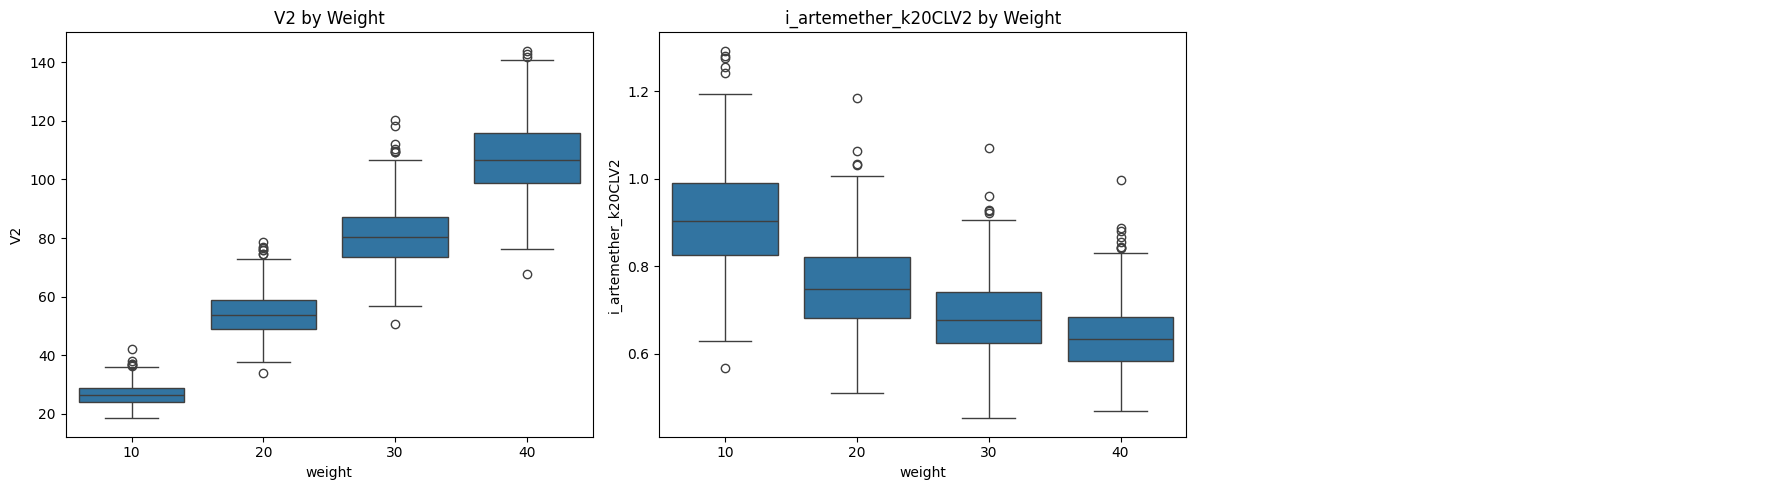

<Figure size 640x480 with 0 Axes>

In [31]:
visualize_all_pk_params(pk_params_dfs_artemether, [10, 20, 30, 40])
